## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

1.15.0
2.2.4


Using TensorFlow backend.


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 2.6MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd Colab/keras-yolo3-master

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/Colab/keras-yolo3-master


In [3]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [0]:
import cv2
if not os.path.exists("TrainImgs/train_images.txt"):
    # 產生訓練集清單 train_images.txt
    def file_inFolder(path, list_name):
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isdir(file_path):
                #listdir(file_path, list_name)
                a = 0
            elif os.path.isfile(file_path):
                list_name.append(file_path)

    folderPath1 = "./TrainImgs/kangaroo/"
    fileList = []
    file_inFolder(folderPath1, fileList)
    folderPath2 = "./TrainImgs/raccoon/"
    file_inFolder(folderPath2, fileList)
    fileList_path = "./TrainImgs/train_images.txt"
    with open(fileList_path, 'a') as list_file:
        for fileName in fileList:
            list_file.write(fileName)
            list_file.write('\n')
            folder, name = os.path.split(fileName)
            augImgName = folder + "/aug_" + name
            if not os.path.exists(augImgName):
                tmpImg = cv2.imread(fileName)
                cv2.flip(tmpImg, 0) # 0:horizontal, 1:vertical, -1:both
                cv2.imwrite(augImgName, tmpImg)
            list_file.write(augImgName)
            list_file.write('\n')
    print("Done writing train list")
else:
    print("train_images.txt exist")

以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [0]:
if not os.path.exists("TrainImgs/train_anno.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    annots = {'kangaroo': './TrainImgs/kangaroo/annotation/', 'raccoon': './TrainImgs/raccoon/annotation/'}

    # 專題的辨識目標 
    categories = ['kangaroo', 'raccoon']

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(annot_path, image_file, list_file):
        image_id = os.path.splitext(os.path.basename(image_file))[0]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation_augHor(annot_path, image_file, list_file):
        tmpImg = cv2.imread(image_file)
        #print("image_file", image_file)
        rows = tmpImg.shape[0]
        cols = tmpImg.shape[1]
        
        image_id = os.path.splitext(os.path.basename(image_file))[0]
        image_id = image_id[4::]
        in_file = open('%s%s.xml' % (annot_path, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in categories or int(difficult)==1:
                continue
            cls_id = categories.index(cls)
            xmlbox = obj.find('bndbox')
            b = ((cols - int(xmlbox.find('xmin').text)), int(xmlbox.find('ymin').text), (cols - int(xmlbox.find('xmax').text)), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    annotation_path = './TrainImgs/train_anno.txt'
    with open(annotation_path, 'a') as list_file:
        print("save annotation at %s" % annotation_path)
        image_files = open('./TrainImgs/train_images.txt').read().strip().split()
        cnt = 0
        for image_file in image_files:
            folder, name = os.path.split(image_file)
            if (name[0]=='r') or (name[4]=='r'):
                annot_path = "./TrainImgs/raccoon/annotation/"
            else:
                annot_path = "./TrainImgs/kangaroo/annotation/"
            list_file.write(image_file)
            if (cnt % 2)==0:
                convert_annotation(annot_path, image_file, list_file)
            else:
                convert_annotation_augHor(annot_path, image_file, list_file)
            list_file.write('\n')
            cnt = cnt + 1
    list_file.close()
else:
    print('annotation data is existed!!')

In [0]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

import warnings
warnings.filterwarnings("ignore")
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [8]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
annotation_path = 'final_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/0304/' # 訓練好的模型儲存的路徑
classes_path = 'final_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=200,
        initial_epoch=100,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 328 samples, val on 36 samples, with batch size 16.




Epoch 1/100
20/20 [==============================] - 99s 5s/step - loss: 4037.3052 - val_loss: 1169.2966

Epoch 2/100
20/20 [==============================] - 23s 1s/step - loss: 676.9225 - val_loss: 303.4176
Epoch 3/100
20/20 [==============================] - 24s 1s/step - loss: 274.3464 - val_loss: 174.6920
Epoch 4/100
20/20 [==============================] - 12s 589ms/step - loss: 182.6253 - val_loss: 138.6100
Epoch 5/100
20/20 [==============================] - 23s 1s/step - loss: 144.1737 - val_loss: 122.7981
Epoch 6/100
20/20 [==============================] - 24s 1s/step - loss: 120.6813 - val_loss: 92.9266
Epoch 7/100
20/20 [==============================] - 23s 1s/ste

In [10]:
from yolo import YOLO
log_dir = 'logs/0304/' # 訓練好的模型儲存的路徑
classes_path = 'final_classes.txt'
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
# r_image = yolo_model.detect_image(image)













logs/0304/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(416, 416, 3)
Found 4 boxes for img
kangaroo 0.45 (170, 62) (227, 183)
kangaroo 0.53 (221, 47) (273, 179)
kangaroo 0.66 (4, 47) (68, 181)
kangaroo 0.80 (82, 29) (154, 183)
0.14679486599993652
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (204, 432) (422, 720)
kangaroo 0.43 (368, 94) (780, 644)
kangaroo 0.73 (483, 0) (1182, 720)
0.16695683500006453
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (176, 64) (364, 252)
kangaroo 0.91 (52, 29) (189, 252)
0.13299548600002709
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (47, 46) (160, 168)
kangaroo 0.93 (101, 0) (235, 168)
0.12940990199990665
(416, 416, 3)
Found 2 boxes for img
raccoon 0.99 (150, 25) (296, 168)
kangaroo 0.88 (1, 34) (141, 168)
0.13088812099999814
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (9, 54) (140, 174)
0.12816333699993265
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (0, 38) (100, 190)
raccoon 0.56 (174, 17) (262, 138)
0.12204038200002287
(416, 416, 3)
Found 0 boxes for img
0.1250438929998836
(416, 416

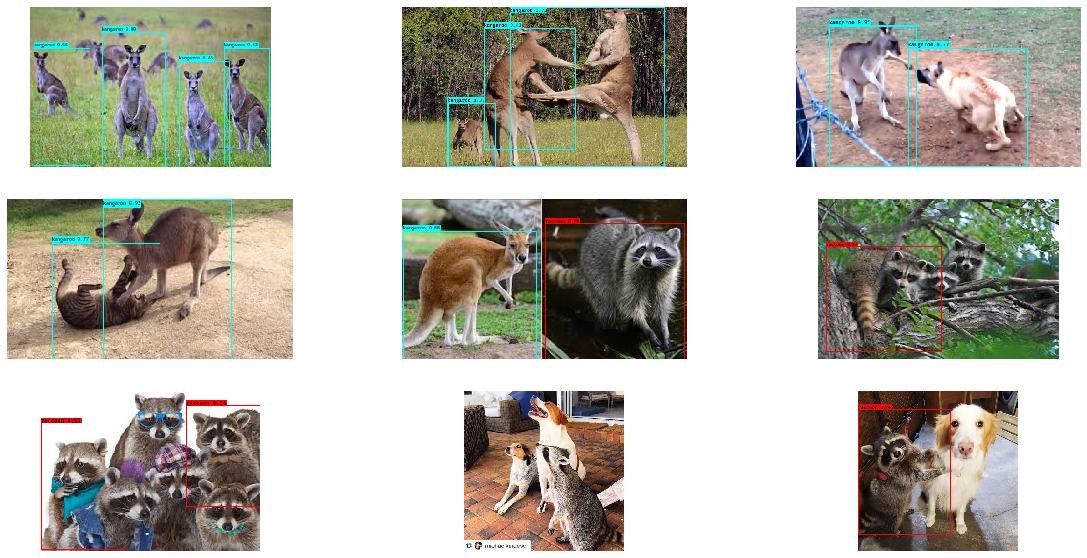

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

plt.figure(figsize=(20,10))
i = 1
for i in range(9):
    imgPath = "testimg" + str(i) + ".jpg"
    image = Image.open(imgPath)
    r_image = yolo_model.detect_image(image)
    plt.subplot(3, 3, i+1)
    plt.imshow(r_image)
    plt.axis('off')